# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
!pip install eli5==0.13.0
!pip install xgboost
!pip install geopy

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [3]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/data/train.csv'
test_path  = '/data/ephemeral/home/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [4]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [5]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [6]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [7]:
# 좌표의 결측치가 모두 채워진 데이터를 concat 변수에 가져온다.
concat_coordinate_path = '/data/ephemeral/home/data/concat_coordinate.csv'

concat = pd.read_csv(concat_coordinate_path, index_col=0)

In [8]:
# 아파트명 결측치가 있다. 
# 아파트 결측치가 있는 데이터를 1000000 부터 시작하여 10000001 과 같이 차례로 아파트명을 채워준다
# 성능개선이 되진 않아서 보류류
# grouped = concat.groupby(['시군구', '좌표X', '좌표Y']).ngroup() + 1000000
# concat['아파트명'] = concat['아파트명'].fillna(grouped.map(lambda x: str(x)))

In [9]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [10]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 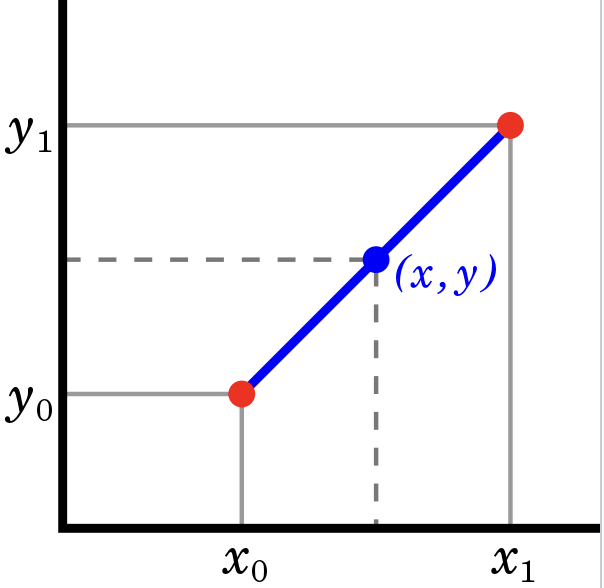

In [11]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [12]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [13]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

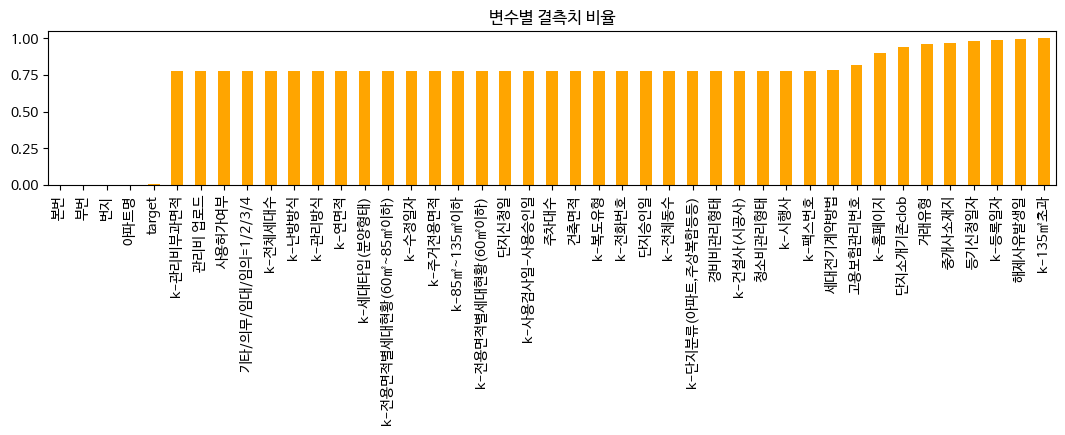

In [14]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [15]:
concat['건축면적'].isnull().sum()

876279

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [16]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [17]:
# 이후에 나올 코드에서 상당히 많은 피처를 drop할 것이기에 기존 코드는 주석처리했다

# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
# selected = list(concat.columns[concat.isnull().sum() <= 1000000])
# concat_select = concat[selected]

In [18]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test'],
      dtype='object')

In [19]:
# concat['is_해제사유발생'] = concat['해제사유발생일'].notnull().astype(int)
# concat.drop('해제사유발생일', inplace=True, axis=1)

In [20]:
# concat['is_해제사유발생'].value_counts()

In [21]:
columns_to_drop = [
    '본번', '부번', '번지', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 
    'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식','k-전체동수','k-전체세대수','k-건설사(시공사)',
    'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',  'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)','k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', 
    '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', 
    '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '해제사유발생일'
]
concat_select = concat.drop(columns=columns_to_drop)

In [22]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구           0
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
좌표X           0
좌표Y           0
target     9272
is_test       0
dtype: int64

In [23]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 11 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   아파트명     1125958 non-null  object 
 2   전용면적     1128094 non-null  float64
 3   계약년월     1128094 non-null  int64  
 4   계약일      1128094 non-null  int64  
 5   층        1128094 non-null  int64  
 6   건축년도     1128094 non-null  int64  
 7   좌표X      1128094 non-null  float64
 8   좌표Y      1128094 non-null  float64
 9   target   1118822 non-null  float64
 10  is_test  1128094 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 103.3+ MB


In [24]:
# 본번 부번은 이전 코드에서 삭제했다

# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
# concat_select['본번'] = concat_select['본번'].astype('str')
# concat_select['부번'] = concat_select['부번'].astype('str')

In [25]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '아파트명']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [26]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [27]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구        0
아파트명       0
전용면적       0
계약년월       0
계약일        0
층          0
건축년도       0
좌표X        0
좌표Y        0
target     0
is_test    0
dtype: int64

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

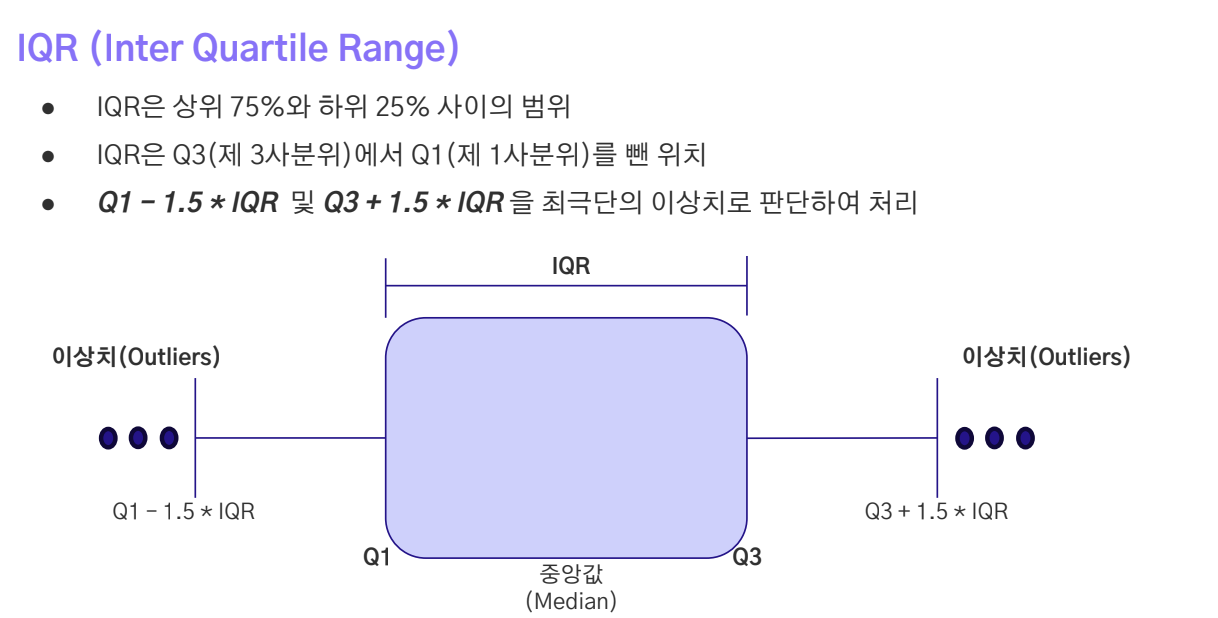

In [28]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 11)


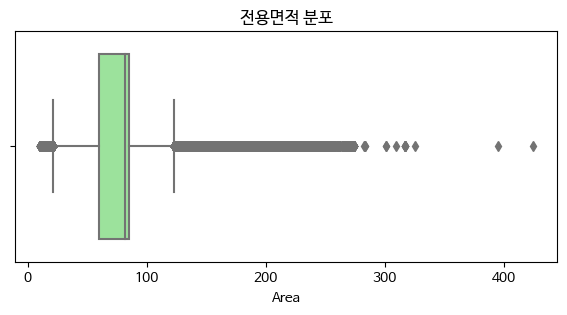

In [29]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [30]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [31]:
# 해당 코드의 이상치 제거는 성능에 심각한 악영향을 끼친다.
# 상당한 정상 데이터도 같이 삭제하기 때문인걸로 추측측

# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
# concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [32]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1128094, 11)


In [33]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [34]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [35]:
concat_select.shape

(1128094, 13)

In [36]:
# # 같은 아파트와 같은 전용면적인 아파트에서 target의 하위 이상치 제거거
# # RMSE도 떨어지고 꽤 괜찮다고 생각하는데, 왜 제출만하면 점수가 높아지지지
# # 이후에 다시 연구가 필요하다. 상당한 정상 데이터를 삭제하기 때문인걸로 생각됨. 확실히 이상치인것만 삭제해야한다다

# def remove_outliers_by_group_target(df_origin):
#     # is_test가 0인 데이터와 1인 데이터를 분리
#     df = df_origin.query('is_test == 0')  # is_test == 0인 데이터만
#     df_test = df_origin.query('is_test == 1')  # is_test == 1인 데이터는 그대로 둠
    
#     # 같은 아파트명, 좌표X, 좌표Y, 계약년을 기준으로 그룹화
#     grouped = df.groupby(['아파트명', '좌표X', '좌표Y', '전용면적'])
    
#     # 조건에 맞는 행 제거
#     to_remove = []
#     for (apartment, x, y, meter), group in grouped:
#         Q1 = group['target'].quantile(0.25)
#         Q3 = group['target'].quantile(0.75)
#         IQR = Q3 - Q1

#         lower_bound = Q1 - 1.5 * IQR
#         # upper_bound = Q3 + 1.5 * IQR

#         outliers = group[group['target'] < lower_bound]
        
#         if len(outliers) == 1:
#             print(f"제거 대상: 아파트명={apartment}, 전용면적={meter}")
#             # outliers에서 제거할 인덱스를 저장
#             to_remove.extend(outliers.index)
    
#     # is_test == 0인 데이터에서 이상치만 제거
#     df_cleaned = df.drop(to_remove)
    
#     # 최종적으로 is_test == 1인 데이터와 합침
#     result = pd.concat([df_cleaned, df_test])
    
#     return result

# # 함수 실행
# concat_select = remove_outliers_by_group_target(concat_select)

# # 확인
# concat_select['is_test'].value_counts()

In [37]:
# 같은아파트에서 하위 전용면적 이상치 제거
# 0.004는 이상치가 맞음 예외없이 이상한 데이터들임임
# 0.008까지 설정해야할듯 0.009부턴 선릉역대우아이빌의 데이터가가 정상인거같음

def remove_outliers_by_group_meter(df_origin):
    # is_test가 0인 데이터와 1인 데이터를 분리
    df = df_origin.query('is_test == 0')  # is_test == 0인 데이터만
    df_test = df_origin.query('is_test == 1')  # is_test == 1인 데이터는 그대로 둠
    
    # 같은 아파트명, 좌표X, 좌표Y, 계약년을 기준으로 그룹화
    grouped = df.groupby(['아파트명', '좌표X', '좌표Y'])
    
    # 조건에 맞는 행 제거
    to_remove = []
    for (apartment, x, y), group in grouped:
        Q1 = group['전용면적'].quantile(0.25)
        Q3 = group['전용면적'].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = group[group['전용면적'] < lower_bound]
        
        outlier_ratio = len(outliers) / len(group)

        # 비율이 8% 이하일 때만 제거
        if 0 < outlier_ratio <= 0.008 and len(outliers) == 1:
            print(f"outlier: {len(outliers)} / group: {len(group)}  = {outlier_ratio}, 아파트: {apartment}")
            to_remove.extend(outliers.index)
    
    # is_test == 0인 데이터에서 이상치만 제거
    df_cleaned = df.drop(to_remove)
    print(df_cleaned.shape)
    # 최종적으로 is_test == 1인 데이터와 합침
    result = pd.concat([df_cleaned, df_test])
    # 아래 코드는 테스트용
    # result = pd.concat([df, df_test])
    return result

# 함수 실행
concat_select = remove_outliers_by_group_meter(concat_select)

# 확인
concat_select['is_test'].value_counts()

outlier: 1 / group: 334  = 0.0029940119760479044, 아파트: 극동그린
outlier: 1 / group: 307  = 0.003257328990228013, 아파트: 상림마을6단지푸르지오BL1-7
outlier: 1 / group: 185  = 0.005405405405405406, 아파트: 천왕이펜하우스1단지
outlier: 1 / group: 143  = 0.006993006993006993, 아파트: 천왕이펜하우스6단지
outlier: 1 / group: 637  = 0.0015698587127158557, 아파트: 코오롱
outlier: 1 / group: 173  = 0.005780346820809248, 아파트: 한양5
(1118816, 13)


0    1118816
1       9272
Name: is_test, dtype: int64

In [38]:
# temp = concat_select[(concat_select['아파트명'] == '코오롱') & (concat_select['동'] == '방이동')]
temp = concat_select[(concat_select['아파트명'] == '한신')]
temp['전용면적'].value_counts()

84.940     2168
59.760      720
68.130      609
89.460      576
59.840      438
84.520      342
50.370      334
132.960     316
84.870      287
84.760      277
84.030      274
59.970      229
84.920      224
44.780      217
114.950     182
129.660     170
45.563      168
114.885     168
35.277      166
84.900      135
113.670     120
152.250      96
59.480       82
83.860       78
52.730       74
59.880       65
52.720       61
40.040       53
82.080       45
57.840       45
58.080       43
107.460      41
37.100       38
62.360       38
84.200       35
46.900       33
84.690       30
84.830       30
84.400       26
81.890       23
81.700       19
78.430       17
81.600       11
77.460       10
44.000        7
83.520        5
56.970        2
78.420        1
Name: 전용면적, dtype: int64

In [39]:
temp[temp['전용면적'] == 20.37]
# temp
temp[(temp['계약년'] == '2022')]
# temp[(temp['계약년'] == '2009') & (temp['동'] == '압구정동')]

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,is_test,구,동,계약년,계약월
204909,한신,57.84,15,11,1991,127.134867,37.545826,49700.0,0,강동구,천호동,2022,10
209572,한신,84.94,6,8,1995,127.047811,37.686279,54500.0,0,도봉구,도봉동,2022,10
209573,한신,84.94,24,1,1995,127.047811,37.686279,54200.0,0,도봉구,도봉동,2022,10
209574,한신,84.94,15,5,1995,127.047811,37.686279,45500.0,0,도봉구,도봉동,2022,11
209575,한신,84.94,14,7,1995,127.047811,37.686279,50000.0,0,도봉구,도봉동,2022,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235743,한신,62.36,18,5,1985,126.884043,37.519310,91000.0,0,영등포구,문래동6가,2022,05
235744,한신,40.04,29,11,1985,126.884043,37.519310,65000.0,0,영등포구,문래동6가,2022,08
238205,한신,59.76,27,20,1997,127.081907,37.597150,73000.0,0,중랑구,중화동,2022,03
238206,한신,59.76,20,3,1997,127.081907,37.597150,74000.0,0,중랑구,중화동,2022,07


In [40]:
# outlier 제거 코드 원본
# def remove_outliers_by_group(df_origin):
#     # is_test가 0인 데이터와 1인 데이터를 분리
#     df = df_origin.query('is_test == 0')  # is_test == 0인 데이터만
#     df_test = df_origin.query('is_test == 1')  # is_test == 1인 데이터는 그대로 둠
    
#     # 같은 아파트명, 좌표X, 좌표Y, 계약년을 기준으로 그룹화
#     grouped = df.groupby(['아파트명', '좌표X', '좌표Y', '계약년'])
    
#     # 조건에 맞는 행 제거
#     to_remove = []
#     for _, group in grouped:
#         # 그룹 내 target의 상위 1%와 하위 1% 값을 구합니다.
#         upper_5_percent = group['target'].quantile(0.99)
#         lower_5_percent = group['target'].quantile(0.01)
        
#         # is_test가 0인 데이터에서 target값이 상위 5% 또는 하위 5%인 데이터를 찾습니다.
#         outliers = group[(group['target'] > upper_5_percent) | (group['target'] < lower_5_percent)]
        
#         # outliers에서 제거할 인덱스를 저장
#         to_remove.extend(outliers.index)
    
#     # is_test == 0인 데이터에서 이상치만 제거
#     df_cleaned = df.drop(to_remove)
    
#     # 최종적으로 is_test == 1인 데이터와 합침
#     result = pd.concat([df_cleaned, df_test])
    
#     return result

# # 함수 실행
# concat_select = remove_outliers_by_group(concat_select)

# # 확인
# concat_select['is_test'].value_counts()

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [41]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [42]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
# concat_select['강남여부'] = is_gangnam

In [43]:
concat_select.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '구', '동', '계약년', '계약월'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [44]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.128088e+06
mean     1.998790e+03
std      9.358525e+00
min      1.961000e+03
10%      1.986000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [45]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
# concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2017 else 0)

In [46]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,is_test,구,동,계약년,계약월
0,개포6차우성,79.97,8,3,1987,127.05721,37.476763,124000.0,0,강남구,개포동,2017,12


In [47]:
concat_select.shape

(1128088, 13)

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

In [48]:
subway = pd.read_csv('/data/ephemeral/home/data/subway_feature.csv')
bus = pd.read_csv('/data/ephemeral/home/data/bus_feature.csv')

In [49]:
subway.head()

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387


In [50]:
bus.shape

(12584, 6)

In [51]:
# 역세권 판단. 너무 오래걸린다
# from geopy.distance import geodesic

# # 1. 대표 좌표 추출
# unique_coords = concat_select[['좌표X', '좌표Y']].drop_duplicates().reset_index(drop=True)

# # 2. 각 아파트 단지와 지하철 역 간의 거리 계산
# def calculate_near_subway(apartment_coords):
#     nearest_subway_name = None
#     nearest_subway_coords = None
#     min_distance = float('inf')  # 초기값을 무한대로 설정
#     for subway_coords in subway[['위도', '경도']].to_numpy():
#         distance = geodesic(apartment_coords, subway_coords).meters
#         min_distance = min(min_distance, distance)
        
#         if distance < min_distance:
#             min_distance = distance
#             nearest_subway_name = subway_row['역명']
#             nearest_subway_coords = subway_coords

#     print(f"아파트 좌표: {apartment_coords} ➡️ 가장 가까운 지하철역: {nearest_subway_name} "
#         f"({nearest_subway_coords}), 거리: {min_distance:.2f}미터")
        
#     return min_distance

# # 3. 500m 이내를 역세권으로 표시
# unique_coords['is_near_subway'] = unique_coords.apply(
#     lambda row: 1 if calculate_near_subway((row['좌표Y'], row['좌표X'])) <= 500 else 0,
#     axis=1
# )

# # 4. 원래 데이터로 거리 값 매핑
# concat_select = pd.merge(
#     concat_select,
#     unique_coords[['좌표X', '좌표Y', 'is_near_subway']],
#     on=['좌표X', '좌표Y'],
#     how='left'
# )

In [52]:
# concat_select['is_near_subway'].value_counts()

In [53]:
# unique_coords = concat_select[['좌표X', '좌표Y']].drop_duplicates().reset_index(drop=True)

In [54]:
# # is_near_subway만 썼을때가 제일 잘됐다
# from scipy.spatial import KDTree

# # 1. 대표 좌표 추출
# unique_coords = concat_select[['좌표X', '좌표Y']].drop_duplicates().reset_index(drop=True)

# # 2. KDTree 생성
# subway_tree = KDTree(subway[['경도', '위도']].to_numpy())

# # 대표 좌표 배열
# unique_coords_array = unique_coords[['좌표X', '좌표Y']].to_numpy()

# # 3. 각 아파트 단지에서 500m 이내의 지하철역 수와 가장 가까운 지하철역 거리 계산
# def get_subway_info(coords, tree, radius=0.005):
#     # 반경 내 지하철역 정보
#     nearby_indices = tree.query_ball_point(coords, radius)
    
#     # 지하철 역 이름과 호선 정보 추출
#     nearby_stations = subway.iloc[nearby_indices]
#     unique_stations = nearby_stations['역사명'].unique()
#     line_count = nearby_stations['호선'].nunique()  # 고유한 호선의 개수

#     # 가장 가까운 지하철역 거리 계산
#     min_distance, _ = tree.query(coords)
#     min_distance_meters = min_distance * 111000  # 도 단위 -> 미터 변환

#     return len(unique_stations), line_count, min_distance_meters  # 역의 개수를 반환

# # 4. 역 이름의 갯수, 호선 개수, 거리 계산
# subway_info = [get_subway_info(coords, subway_tree) for coords in unique_coords_array]
# unique_coords['subway_count_within_500m'], unique_coords['subway_line_count_within_500m'], unique_coords['min_subway_distance'] = zip(*subway_info)

# # 5. 원래 데이터로 매핑 (is_near_subway 피처는 제외)
# concat_select = pd.merge(
#     concat_select,
#     unique_coords[['좌표X', '좌표Y', 'min_subway_distance', 'subway_count_within_500m', 'subway_line_count_within_500m']],
#     on=['좌표X', '좌표Y'],
#     how='left'
# )

In [55]:
# 역세권 원본
# 역세권 여부 판단
# 역세권 판단 코드중 아직까진 이게 제일 성능이 좋음
from scipy.spatial import KDTree

# 1. 대표 좌표 추출
unique_coords = concat_select[['좌표X', '좌표Y']].drop_duplicates().reset_index(drop=True)

# 2. KDTree 생성 및 거리 계산
# 지하철 거리 및 역세권 판단
subway_tree = KDTree(subway[['경도', '위도']].to_numpy())

# 대표 좌표에서 최근접 지하철 거리 계산
unique_coords_array = unique_coords[['좌표X', '좌표Y']].to_numpy()
subway_distances, _ = subway_tree.query(unique_coords_array)

# 500m 이내를 역세권으로 표시
unique_coords['is_near_subway'] = (subway_distances <= 0.005).astype(int)

# 3. 원래 데이터로 거리 값 매핑
concat_select = pd.merge(
    concat_select,
    unique_coords[['좌표X', '좌표Y', 'is_near_subway']],
    on=['좌표X', '좌표Y'],
    how='left'
)

In [56]:
# concat_select['is_near_subway'].value_counts()

In [57]:
# # 특정 동 리스트 설정
# # dong = ['한남동', '청담동']

# dong = [
#     '한남동', '청담동', '압구정동', '서초동', '방배동', '신사동', '삼성동',
#     '잠원동', '논현동', '도곡동', '개포동', '잠실동', '반포동', '일원동',
#     '잠실본동', '내곡동', '염곡동', '우면동', '신천동'
# ]
# # 'is_high_price_area'라는 새로운 피처 추가
# concat_select['is_high_price_area'] = concat_select['동'].apply(lambda x: 1 if x in dong else 0)

# # 결과 확인
# concat_select.head()

대장 아파트 피처

In [58]:
# 지역구별 대장 아파트들을 입력합니다.
lead_house = {
    "강서구" : (37.56520754904415, 126.82349451366355),
    "관악구" : (37.47800896704934, 126.94178722423047),
    "강남구" : (37.530594054209146, 127.0262701317293),
    "강동구" : (37.557175745977375, 127.16359581113558),
    "광진구" : (37.543083184171, 127.0998363490422),
    "구로구" : (37.51045944660659, 126.88687199829572),
    "금천구" : (37.459818907487936, 126.89741481874103),
    "노원구" : (37.63952738902813, 127.07234254197617),
    "도봉구" : (37.65775043994647, 127.04345013224447),
    "동대문구" : (37.57760781415707, 127.05375628992316),
    "동작구" : (37.509881249641495, 126.9618159122961),
    "마포구" : (37.54341664563958, 126.93601641235335),
    "서대문구" : (37.55808950436837, 126.9559315685538),
    "서초구" : (37.50625410912666, 126.99846468032919),
    "성동구" : (37.53870643389788, 127.04496220606433),
    "성북구" : (37.61158435092128, 127.02699796439015),
    "송파구" : (37.512817775046074, 127.08340371063358),
    "양천구" : (37.526754982736556, 126.86618704123521),
    "영등포구" : (37.52071403351804, 126.93668907644046),
    "용산구" : (37.521223570097305, 126.97345317787784),
    "은평구" : (37.60181702377437, 126.9362806808709),
    "종로구" : (37.56856915384472, 126.96687674967252),
    "중구" : (37.5544678205846, 126.9634879236162),
    "중랑구" : (37.58171824083332, 127.08183326205129),
    "강북구" : (37.61186335979484, 127.02822407466175)
}

In [59]:
import math
# 위경도를 이용해 두 지점간의 거리를 구하는 함수를 생성합니다.
def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = radius * c
    return distance

In [60]:
# # 대장 아파트의 위경도 데이터프레임을 구성합니다.
# lead_house_data = pd.DataFrame([{"구": k, "대장_좌표X": v[1], "대장_좌표Y": v[0]} for k, v in lead_house.items()])
# # 데이터프레임간 결합을 합니다.
# concat_select = pd.merge(concat_select, lead_house_data, how="inner", on="구")
# # 아까 제작한 haversine_distance 함수를 이용해 대장아파트와의 거리를 계산하고, 새롭게 컬럼을 구성합니다.
# concat_select['대장아파트_거리'] = concat_select.apply(lambda row: haversine_distance(row["좌표Y"], row["좌표X"], row["대장_좌표Y"], row["대장_좌표X"]), axis=1)

In [61]:
avg_price_by_dong = concat_select.groupby(['구', '동'])['target'].mean().reset_index()
avg_price_by_dong.rename(columns={'target': 'avg_price_by_dong'}, inplace=True)

# 2. concat_select에 동별 평균가격 피처 추가
concat_select = pd.merge(
    concat_select,
    avg_price_by_dong[['구', '동', 'avg_price_by_dong']],
    on=['구', '동'],
    how='left'
)

In [62]:
concat_select.head()

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,is_test,구,동,계약년,계약월,is_near_subway,avg_price_by_dong
0,개포6차우성,79.97,8,3,1987,127.05721,37.476763,124000.0,0,강남구,개포동,2017,12,0,92107.125518
1,개포6차우성,79.97,22,4,1987,127.05721,37.476763,123500.0,0,강남구,개포동,2017,12,0,92107.125518
2,개포6차우성,54.98,28,5,1987,127.05721,37.476763,91500.0,0,강남구,개포동,2017,12,0,92107.125518
3,개포6차우성,79.97,3,4,1987,127.05721,37.476763,130000.0,0,강남구,개포동,2018,01,0,92107.125518
4,개포6차우성,79.97,8,2,1987,127.05721,37.476763,117000.0,0,강남구,개포동,2018,01,0,92107.125518


In [63]:
# 구별 평균가격은 동별에 비해 성능이 떨어짐

# mean_price_by_gu = concat_select.groupby('구')['target'].mean().sort_values()

In [64]:
# mean_price_by_gu = concat_select.groupby('구')['target'].mean().sort_values(ascending=False)

# # 시각화
# plt.figure(figsize=(12, 8))
# sns.barplot(x=mean_price_by_gu.values, y=mean_price_by_gu.index, palette='viridis')
# plt.title('Average Apartment Price by District (구)', fontsize=16)
# plt.xlabel('Average Price', fontsize=14)
# plt.ylabel('District (구)', fontsize=14)
# plt.show()

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [65]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118816, 14) (9272, 14)


In [66]:
dt_test.head(1)

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,구,동,계약년,계약월,is_near_subway,avg_price_by_dong
1118816,개포6차우성,79.97,26,5,1987,127.05721,37.476763,13250.0,강남구,개포동,2023,07,0,92107.125518


In [67]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

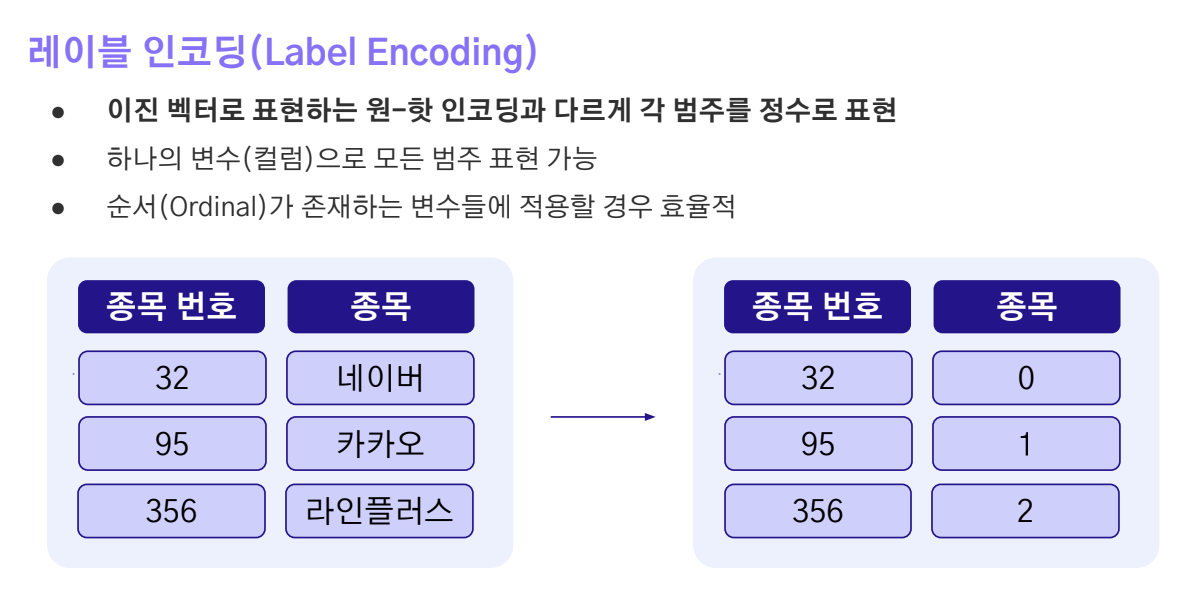

In [68]:
# 구별 평균가격 rank 피처 아래 코드에서 drop으로 삭제예정
# 바로 다음 블록 코드에서 동별 평균가격 rank 피처가 있는데, 그게 성능이 더 좋다

mean_price_by_gu = dt_train.groupby('구')['target'].mean().sort_values()
gu_rank = {gu: rank for rank, gu in enumerate(mean_price_by_gu.index, 1)}

dt_train['구_rank'] = dt_train['구'].map(gu_rank)
dt_test['구_rank'] = dt_test['구'].map(gu_rank)

dt_train.drop('구', axis=1, inplace=True)
dt_test.drop('구', axis=1, inplace=True)

In [69]:
mean_price_by_dong = dt_train.groupby('동')['target'].mean().sort_values()
dong_rank = {dong: rank for rank, dong in enumerate(mean_price_by_dong.index, 1)}

dt_train['동_rank'] = dt_train['동'].map(dong_rank)
dt_test['동_rank'] = dt_test['동'].map(dong_rank)

dt_train.drop('동', axis=1, inplace=True)
dt_test.drop('동', axis=1, inplace=True)

In [70]:
dt_train.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', '계약년',
       '계약월', 'is_near_subway', 'avg_price_by_dong', '구_rank', '동_rank'],
      dtype='object')

In [71]:
# 계약일 피처는 성능에 악영향을 끼치는것으로 보임. 계약년과 계약월이 있어서 삭제해도 괜찮을듯. 계약년과 계약월은 필수다
columns_to_drop = [
    '구_rank', '계약일'
]

dt_train = dt_train.drop(columns=columns_to_drop)
dt_test = dt_test.drop(columns=columns_to_drop)

In [72]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_near_subway', 'avg_price_by_dong', '동_rank']
범주형 변수: ['아파트명', '계약년', '계약월']


In [73]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


In [74]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,아파트명,전용면적,층,건축년도,좌표X,좌표Y,target,계약년,계약월,is_near_subway,avg_price_by_dong,동_rank
0,328,79.97,3,1987,127.05721,37.476763,124000.0,10,11,0,92107.125518,290


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 XGBoost 이용하겠습니다.
- 마크다운에 RandomForest관련 사항은 삭선표시해두었습니다.

In [75]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [76]:
dt_test.shape

(9272, 12)

In [77]:
# 시간이 있다면 K-fold 검증을 해보면 좋다다

# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']

# y_train = np.log1p(dt_train['target'])


X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [78]:
import xgboost

model=xgboost.XGBRegressor(
    device='gpu'
)

### 하이퍼파라미터 탐색을 위한 코드

- GridSearch와 RandomSearch 중 선택을 고민했습니다
- GridSearch는 모든 경우의 수를 따져서 시간이 많이 소요되므로 RandomSearch 를 선택했습니다.
- 최적의 하이퍼파라미터를 이미 찾아 아래 코드에서 사용하고있으니 앞으로 실행할 필요는 없습니다.

In [79]:

# base_score=[0.25,0.5,0.7]

# n_estimators = [500, 1000, 1500, 2000]
# max_depth = [3, 5, 7, 10]
# booster=['gbtree']
# learning_rate=[0.01, 0.03, 0.05, 0.1]
# min_child_weight=[1, 5, 10]

# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'max_depth':max_depth,
#     'learning_rate':learning_rate,
#     'min_child_weight':min_child_weight,
#     'booster':booster,
#     'base_score':base_score
#     }

# random_cv = RandomizedSearchCV(estimator=model,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = -1,
#             verbose = 5, 
#             return_train_score = True,
#             random_state=42)


In [80]:
# random_cv.fit(X_train, y_train)

In [81]:
# random_cv.best_params_

In [82]:
# random_cv.best_score_

### 하이퍼파라미터 선택지들

* 현재까지 파악된 제일 좋은 점수를 보이는 하이퍼파라미터는 learningRate=0.05, n_estimator=5000 입니다.
* 하지만 n_estimator변수의 값이 높으면 과적합 우려가 있습니다.
* 추후 EDA가 완료된 후 n_estimator값이 낮은 모델로도 학습 후 테스트가 필요합니다.
* 추가 테스트 결과 early_stopping을 쓰는것이 학습에 더 도움이 됩니다.
* 최적의 학습구간을 스스로 찾고, 과적합이 되기 전에 학습을 중단하기 떄문인것으로 보입니다.

각 하이퍼파라미터별로 상단에 점수를 기재해두었습니다.


In [83]:
#44490
# n_estimators가 작다
# EDA가 완료된 후 아래 파라미터로도 학습 후 테스트가 필요요
# model=xgboost.XGBRegressor(
#  n_estimators= 900,
#  learning_rate= 0.15,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.25)
 
# 45045.5677
# model=xgboost.XGBRegressor(
#  n_estimators= 1500,
#  learning_rate= 0.1,
#  max_depth= 10,
#  min_child_weight= 1,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

# 43815.4360
# RMSE test: 4280.667057047746
# model=xgboost.XGBRegressor(
#  n_estimators= 2000,
#  learning_rate= 0.05,
#  max_depth= 10,
#  min_child_weight= 5,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

# 43752.7333
# RMSE test: 4226.164120555658
# model=xgboost.XGBRegressor(
#  n_estimators= 3000,
#  learning_rate= 0.05,
#  max_depth= 10,
#  min_child_weight= 5,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

In [84]:

# n_estimators가 꽤 큰값이라 과적합 우려가 있습니다다.
# EDA가 끝나고 n_estimator가 작은 하이퍼파라미터로 학습을 시키고 점수를 비교해봐야 합니다.
# early_stop을 사용하지 않는것 중 현재까지 제일 성능이 좋은 하이퍼파라미터 입니다.
# 43735.7052
# RMSE test: 4206.333504214999
# model=xgboost.XGBRegressor(
#  n_estimators= 5000,
#  learning_rate= 0.05,
#  max_depth= 10,
#  min_child_weight= 5,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

In [85]:
# model.fit(X_train,y_train)

In [86]:
# # 기존 하이퍼파라미터와 큰 차이는 없다
model = xgboost.XGBRegressor(
    n_estimators=100000,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=5,
    booster='gbtree',
    device='cuda',
    base_score=0.5,
    eval_metric='rmse',
    early_stopping_rounds=1000,
)

In [87]:
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-rmse:70572.05853
[1]	validation_0-rmse:67213.68973
[2]	validation_0-rmse:64031.02736
[3]	validation_0-rmse:61010.16845
[4]	validation_0-rmse:58148.87641
[5]	validation_0-rmse:55433.36460
[6]	validation_0-rmse:52857.78478
[7]	validation_0-rmse:50414.65331
[8]	validation_0-rmse:48102.76774
[9]	validation_0-rmse:45907.40893
[10]	validation_0-rmse:43826.96229
[11]	validation_0-rmse:41850.43301
[12]	validation_0-rmse:39985.43068
[13]	validation_0-rmse:38213.26278
[14]	validation_0-rmse:36544.83416
[15]	validation_0-rmse:34951.73966
[16]	validation_0-rmse:33447.95973
[17]	validation_0-rmse:32025.81336
[18]	validation_0-rmse:30681.95681
[19]	validation_0-rmse:29415.11297
[20]	validation_0-rmse:28207.22300
[21]	validation_0-rmse:27074.56701
[22]	validation_0-rmse:26010.64535
[23]	validation_0-rmse:24992.56028
[24]	validation_0-rmse:24041.05454
[25]	validation_0-rmse:23136.45217
[26]	validation_0-rmse:22292.22935
[27]	validation_0-rmse:21488.42859
[28]	validation_0-rmse:20735.8

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=1000,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [88]:
pred = model.predict(X_val)
# pred_log = model.predict(X_val)
# pred = np.expm1(pred_log)

In [89]:
# print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred_log))}')

~~- 포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다~~

In [90]:
# y_val = np.expm1(y_val)
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 5801.031807761221


- 변수 중요도도 확인해보도록 하겠습니다.

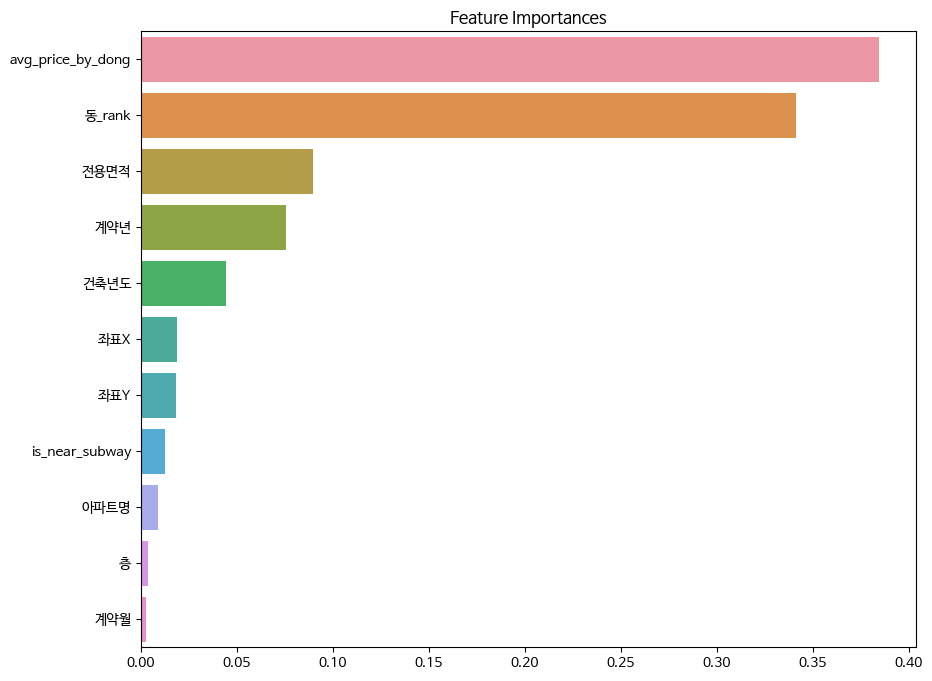

In [91]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [92]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [93]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1077042889.2480 ± 3939334.9182,계약년
1021323313.1903 ± 13556160.4337,전용면적
684903104.6063 ± 5868725.8832,avg_price_by_dong
289952365.7802 ± 1353377.1235,건축년도
186002890.0823 ± 3974450.6032,좌표Y
136840395.8314 ± 3040769.2227,좌표X
81756246.1140 ± 1028487.1100,동_rank
43529635.2981 ± 310652.8700,아파트명
31349217.4921 ± 810217.7017,계약월
21150671.7300 ± 816527.8015,층


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [94]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [95]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [96]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [97]:
X_val_sort.head(1)

,아파트명,전용면적,층,건축년도,좌표X,좌표Y,계약년,계약월,is_near_subway,avg_price_by_dong,동_rank,target,pred,error
381818,5931,187.69,3,2015,127.012469,37.536403,13,5,0,162187.609467,329,167000.0,557420.0,1.524278e+11


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [98]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

# 따로 로그를 찍기 위해 작성한 코드
# X_val_sort_top100 = X_val.sort_values(by='error', ascending=False)
# X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(1000)

In [99]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])


# 따로 로그를 찍기 위해 작성한 코드
# error_top100 = X_val_sort_top100.copy()
# for column in categorical_columns_v2 :    
#     error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

# best_top100 = X_val_sort_tail100.copy()
# for column in categorical_columns_v2 :     
#     best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [100]:
display(error_top100.head(2))
display(best_top100.head(2))

,아파트명,전용면적,층,건축년도,좌표X,좌표Y,계약년,계약월,is_near_subway,avg_price_by_dong,동_rank,target,pred,error
381818,한남동UNVILLAGE루하우스,187.69,3,2015,127.012469,37.536403,2020,06,0,162187.609467,329,167000.0,557420.000,1.524278e+11
221946,르가든더메인한남,227.37,2,2019,127.009942,37.531536,2023,06,1,162187.609467,329,465000.0,805867.875,1.161909e+11


,아파트명,전용면적,층,건축년도,좌표X,좌표Y,계약년,계약월,is_near_subway,avg_price_by_dong,동_rank,target,pred,error
144451,삼익그린1차,78.94,3,1980,127.145685,37.551510,2009,05,1,56840.292024,201,48000.0,47998.972656,1.055435
832825,방주아크빌,76.57,2,2002,126.840622,37.524762,2014,08,0,32631.211973,60,23100.0,23101.007812,1.015686


In [101]:
# error_temp = error_top100[(error_top100['아파트명']=='상암월드컵파크9단지') & (error_top100['전용면적'] == 84.98)& (error_top100['계약년'] == '2010')]

In [102]:
# error_temp

In [103]:
# t = concat_select[concat_select['is_test'] == 0]
# temp = t[(t['아파트명']=='상림마을6단지푸르지오BL1-7') & (t['전용면적'] == 39.83)]
# temp = t[(t['아파트명']=='상림마을6단지푸르지오BL1-7')]
# temp = t[(t['아파트명']=='한남더힐')]
# temp = concat_select[(concat_select['아파트명']=='상암월드컵파크9단지') & (concat_select['전용면적'] == 84.98)]

In [104]:
# temp = t[(t['아파트명']=='한남더힐') & (t['전용면적'] == 208.478) & (t['계약년'] == '2021')]
# temp = temp.sort_values('전용면적', ascending=True)
# temp = temp[temp['전용면적'] == 59.686]

In [105]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 아파트명별로 박스플롯 그리기
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=temp, x='아파트명', y='target')
# plt.xticks(rotation=90)
# plt.show()

In [106]:
# temp = concat[(concat['아파트명'] == '상림마을6단지푸르지오BL1-7')&(concat['전용면적'] == 39.8300)]	
# temp = concat[(concat['아파트명'] == '상림마을6단지푸르지오BL1-7')&(concat['target'] == 112000.0)]
# temp = concat_select[concat_select['아파트명'] == '상림마을6단지푸르지오BL1-7']
# temp.head(30)
temp_sort = temp.sort_values('target', ascending=False)

In [107]:
# temp.head(30)
# temp_sort = temp.sort_values('target', ascending=False)
# temp_sort.head(1)
# temp_sort.value_counts().sum()

- 이제 분포를 비교해보도록 하겠습니다.

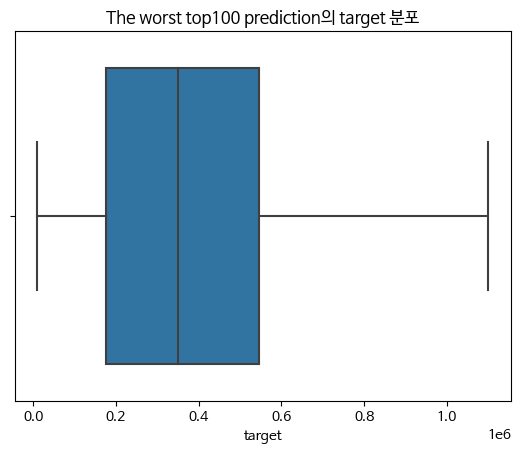

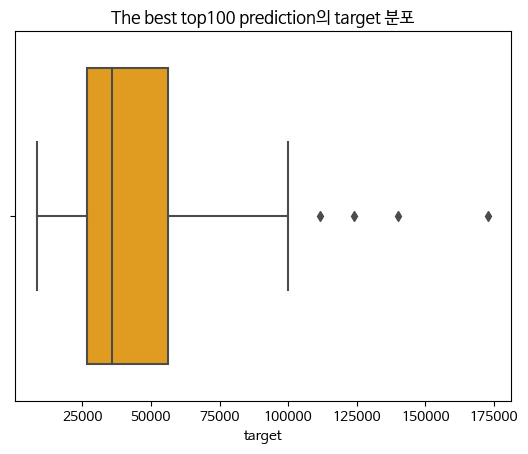

In [108]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

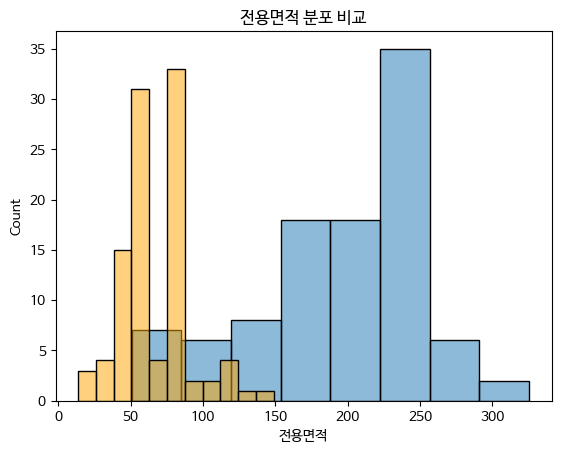

In [109]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [110]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,아파트명,전용면적,층,건축년도,좌표X,좌표Y,target,계약년,계약월,is_near_subway,avg_price_by_dong,동_rank
1118816,328,79.9700,5,1987,127.057210,37.476763,0,16,6,0,92107.125518,290
1118817,329,108.2017,10,2021,127.056394,37.484892,0,16,7,1,92107.125518,290


In [111]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [112]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)
# real_test_pred = np.expm1(real_test_pred)

CPU times: user 135 ms, sys: 16.6 ms, total: 152 ms
Wall time: 92.1 ms


In [113]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([188260.28, 375820.5 , 347196.78, ...,  83078.52,  72118.56,
        72627.86], dtype=float32)

## 7. Output File Save

In [114]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)